In [71]:
%pylab inline

import scipy.stats as stat
import sklearn.linear_model as lm
import scipy.optimize as opt
import pandas as pd
from scipy.ndimage.interpolation import shift

rcParams['figure.figsize'] = (12,8)
rcParams['axes.grid'] = True

Populating the interactive namespace from numpy and matplotlib


In [72]:
import pandas_datareader.data as web

In [73]:
df = web.DataReader('TSLA', 'stooq').Close.iloc[::-1]

In [74]:
N = lambda x: stat.norm.cdf(x)
def BS_value(K,T,PC,S0,sigma,r,q):
    if T == 0:
        return max(S0 - K, 0) if PC == 'C' else max(K - S0, 0)
    d1 = (np.log(S0/K) + (r - q + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if PC == 'C':
        return N(d1)*S0 - N(d2)*K*np.exp(-r*T)
    elif PC == 'P':
        return N(-d2)*K*np.exp(-r*T) - N(-d1)*S0
    
def BS_delta(K,T,PC,S0,sigma,r,q):
    if T == 0:
        return 1*(S0 > K) if PC == 'C' else -1*(S0 < K)
    d1 = (np.log(S0/K) + (r - q + sigma**2/2)*T)/(sigma*np.sqrt(T))
    if PC == 'C':
        return N(d1)
    elif PC == 'P':
        return N(-d1)

In [126]:
"""
generate hedged p&l for option (K, PC, T) assuming hedging on vol sigma, risk-free r, cost of carry q. 

S_t has index 0...T-1
"""
def process(K, T, PC, S_t, sigma, r, q):
    value_func = np.vectorize(lambda S0,t: BS_value(K*S_t.iloc[0],(T-t-1)/252,PC,S0,sigma,r,q))
    delta_func = np.vectorize(lambda S0,t: BS_delta(K*S_t.iloc[0],(T-t-1)/252,PC,S0,sigma,r,q))
    
    values = pd.Series(value_func(S_t,S_t.index),index=S_t.index)
    deltas = pd.Series(delta_func(S_t,S_t.index),index=S_t.index)

    return values-values.shift(1) - deltas.shift(1)*(S_t - S_t.shift(1))

In [151]:
def backtest(K, T, PC, S_t, sigma, r, q):
    pnls = np.zeros(len(S_t)-T)
    for t0 in range(len(S_t)-T):
        pnls[t0] = process(K, T, PC, S_t.iloc[t0:t0+T].reset_index(drop=True), sigma, r, q).sum()
    return pnls

In [152]:
pnls = backtest(1.0, 64, 'C', df, 0.70, 0, 0)

AttributeError: 'int' object has no attribute 'index'

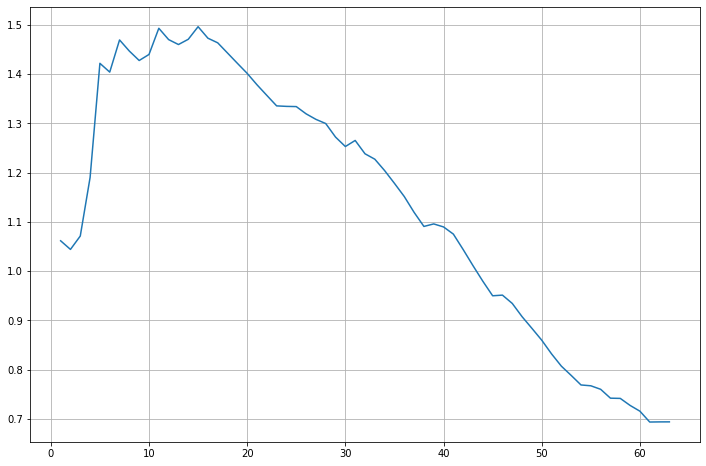

In [145]:
plot(process(1.0, 'C', 0.8, 0, 0, 64, df.iloc[:64].reset_index(drop=True)).cumsum())